# Timeshift

In [593]:
import numpy as np
import bisect
import matplotlib.pyplot as plt
import pimc # custom module
from scipy.stats import truncexpon
from scipy.integrate import quad, simps
import importlib
importlib.reload(pimc)

<module 'pimc' from '/Users/ecasiano/Desktop/LatticePIMC/src/pimc.py'>

### Create a worldline configuration (with a worm)

head_loc:  [0, 1]
tail_loc:  [0, 2]
worm_length: -0.9999999999999996


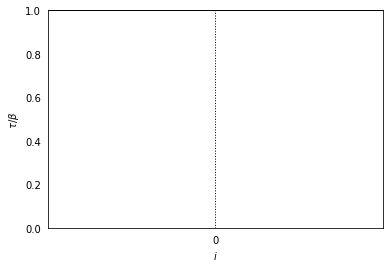

In [674]:
# Check for mu = 0.1,1,10

    # shift_head , worm # ok!
    # shift_head , antiworm # ok!
    # shift_tail , worm # ok!
    # shift_tail , antiworm # ok!

importlib.reload(pimc)
# Simulation parameters
t = 0
U = 1
mu = 10
    
# PIMC parameters
beta = 1
eta = 1      # worm end fugacity

# Canonical or Grand Canonical?
canonical = False

# Create a worldline configuration
L = 1
N = 1
alpha = []
for i in range(L):
    alpha.append(N)
data_struct = pimc.create_data_struct(alpha)
head_loc = []
tail_loc = []

# Machine epsilon
epsilon = np.finfo(float).eps

# Insertion site
i = 0

# Type of worm
insert_worm = False

# Original particles on site
n_i = N

# worm 
if insert_worm:
    tau_h = beta - epsilon
    tau_t = 0 + epsilon
    data_struct[i].append([tau_t,n_i+1,(i,i)])
    data_struct[i].append([tau_h,n_i,(i,i)])
    tail_loc = [i,1]
    head_loc = [i,2]

# antiworm
else:
    tau_h = 0 + epsilon
    #tau_h = beta/2
    tau_t = beta - epsilon
    #tau_t = beta/2
    data_struct[i].append([tau_h,n_i-1,(i,i)])
    data_struct[i].append([tau_t,n_i,(i,i)]) 
    head_loc = [i,1]
    tail_loc = [i,2]
    
print("head_loc: ",head_loc)
print("tail_loc: ",tail_loc)
print("worm_length: %.16f"%(tau_h-tau_t))

pimc.view_worldlines(data_struct,beta,figure_name=None)

### Do many timeshifts

In [675]:
importlib.reload(pimc)
# Do timeshift many times on the above configuration
mc_steps = int(1E+04)
worm_lengths = np.zeros(mc_steps)  # create array to save worm lengths
worm_contractions = np.zeros(mc_steps) # stores contractions of worms
accepted = 0
rejected = 0
r_list = []
for m in range(mc_steps):
    #[time,N,(src,dest)]
    tau_h = data_struct[head_loc[0]][head_loc[1]][0]
    tau_t = data_struct[tail_loc[0]][tail_loc[1]][0]
    worm_length = tau_h-tau_t
    
    # Worm length correction if antiworm is present
    if worm_length < 0:
        worm_length += beta
        
    worm_lengths[m] = worm_length
    
    pimc.worm_timeshift(data_struct,beta,head_loc,tail_loc, U, mu,
                       canonical,N)
    
    # Count accepted updates  
    if tau_h != data_struct[head_loc[0]][head_loc[1]][0] or (
       tau_t != data_struct[tail_loc[0]][tail_loc[1]][0] ):
        accepted += 1

    # Count rejected updates  
    if tau_h == data_struct[head_loc[0]][head_loc[1]][0] and (
       tau_t == data_struct[tail_loc[0]][tail_loc[1]][0] ):
        rejected += 1
    
# Print the number of accepted time shifts
print("Accepted: %.4f %%"%(accepted/mc_steps*100))
print("Rejected: %.4f %%"%(rejected/mc_steps*100))

Accepted: 100.0000 %
Rejected: 0.0000 %


### Histogram of worm lengths

In [676]:
# Histogram of worm lengths
b = beta
loc = 0

# Calculate change in diagonal energy after/before worm end (need this for scale)
x = head_loc[0]
k = head_loc[1]
n_f = data_struct[x][k][1]       # after
n_o = data_struct[x][k-1][1]     # before
dV = (U/2)*(n_o*(n_o-1)-n_f*(n_f-1)) - mu*(n_o-n_f)
if dV == 0: 
    dV = np.finfo(float).eps
scale = 1/abs(dV)

# Generate truncated exponential distribution of worm lengths
tau_w = np.linspace(0,beta,int(1E+02+1))                    # worm lengths
tau_w = (tau_w[1:]+tau_w[0:-1])/2
pdf = truncexpon.pdf(tau_w,b=b/scale,loc=loc,scale=scale)
if dV < 0:
    pdf = truncexpon.pdf(-tau_w+b,b=b/scale,loc=loc,scale=scale)

# Rescale & normalize the truncated exponential pdf
if tau_t < tau_h:
    pdf *= (beta-tau_w)     # worm
else:
    pdf *= (tau_w)           # antiworm?
pdf /= simps(pdf,tau_w)

#pdf_1 = pdf*(beta-tau_w)
#pdf_1 /= simps(pdf_1,tau_w)
#pdf_2 = pdf*(tau_w)
#pdf_2 /= simps(pdf_2,tau_w)
#pdf_3 = ( pdf_1  + pdf_2 ) / simps(pdf_1+pdf_2,tau_w)

# Sampled worm lengths
n, bins = np.histogram(worm_lengths, bins=tau_w, density=1) # for histogram


In [677]:
print(dV)

-10.0


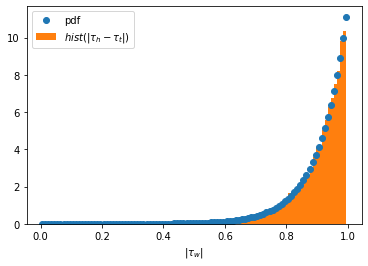

In [678]:
# Plot
fig, ax = plt.subplots(1, 1)
ax.plot(tau_w,pdf,label='pdf',linestyle='None',marker='o')
ax.hist(worm_lengths,bins=bins,density=True,histtype='stepfilled',alpha=1,label=r'$hist(\vert\tau_h-\tau_t\vert)$')
ax.set_xlabel(r"$\vert \tau_w \vert $") ;
#ax.set_yscale("log");
plt.legend() ;
plt.savefig("timeshift_%d_%d_%.4f_%.4f_%.4f_%.4f_%d_anti.pdf"%(L,N,U,mu,t,eta,mc_steps))

### Timeshift a ground state (edge) worm

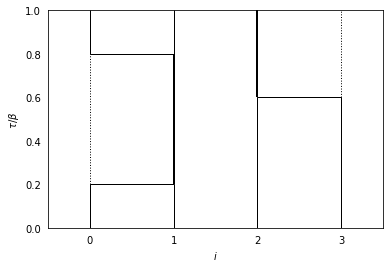

In [583]:
# Create worldline configuration
data_struct = []
x1 = [[0,1,(0,0)],[0.2,0,(0,1)],[0.8,1,(1,0)]]
x2 = [[0,1,(1,1)],[0.2,2,(0,1)],[0.8,1,(1,0)]]
x3 = [[0,1,(2,2)],[0.6,2,(3,2)]]
x4 = [[0,1,(3,3)],[0.6,0,(3,2)]]
data_struct.append(x1)
data_struct.append(x2)
data_struct.append(x3)
data_struct.append(x4)
pimc.view_worldlines(data_struct,beta,figure_name=None)

In [186]:
# Insert worm end from tau = 0
head_loc = []
tail_loc = []
pimc.insert_gsworm_zero(data_struct,beta,head_loc,tail_loc,U,mu,eta)
pimc.view_worldlines(data_struct,beta,figure_name=None)
print("head_loc: ",head_loc)
print("tail_loc: ",tail_loc)

TypeError: insert_gsworm_zero() missing 2 required positional arguments: 'canonical' and 'N'

In [187]:
# Timeshift the worm end
pimc.worm_timeshift(data_struct,beta,head_loc,tail_loc, U, mu)
pimc.view_worldlines(data_struct,beta,figure_name=None)
print(head_loc)
print(tail_loc)

TypeError: worm_timeshift() missing 2 required positional arguments: 'canonical' and 'N'

### Timeshift a worm end near $\tau = \beta$

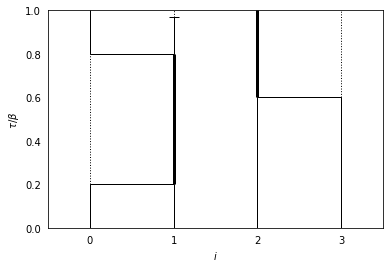

head_loc:  [1, 3]
tail_loc:  []


In [106]:
# Create worldline configuration
data_struct = []
x1 = [[0,1,(0,0)],[0.2,0,(0,1)],[0.8,1,(1,0)]]
x2 = [[0,1,(1,1)],[0.2,2,(0,1)],[0.8,1,(1,0)]]
x3 = [[0,1,(2,2)],[0.6,2,(3,2)]]
x4 = [[0,1,(3,3)],[0.6,0,(3,2)]]
data_struct.append(x1)
data_struct.append(x2)
data_struct.append(x3)
data_struct.append(x4)

# Insert worm end from tau = beta
head_loc = []
tail_loc = []
pimc.insert_gsworm_beta(data_struct,beta,head_loc,tail_loc,U,mu,eta)
pimc.view_worldlines(data_struct,beta,figure_name=None)
print("head_loc: ",head_loc)
print("tail_loc: ",tail_loc)

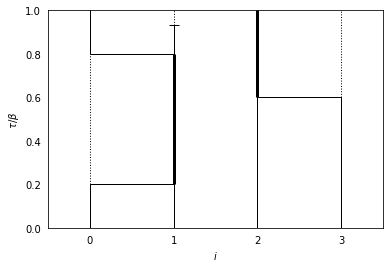

[1, 3]
[]


In [112]:
# Timeshift the worm end
pimc.worm_timeshift(data_struct,beta,head_loc,tail_loc, U, mu)
pimc.view_worldlines(data_struct,beta,figure_name=None)
print(head_loc)
print(tail_loc)